In [36]:
import wave
import numpy as np
#import pyaudio


wave_fname = 'recording-amit.wav'
# wave_fname = 'recording-aba.wav'
sample_width_to_dtype = { 1: np.int8, 2: np.int16, 4: np.int32}
with wave.open(wave_fname, 'rb') as wav_file:
    # wave file parameters
    sample_rate = wav_file.getframerate()
    num_channels = wav_file.getnchannels()
    n_bytes_per_sample = wav_file.getsampwidth()
    
    print(f"wave filename {wave_fname}: sample_rate {sample_rate} num_channels " + \
          f"{num_channels} n_bytes_per_sample {n_bytes_per_sample}")
    if (n_bytes_per_sample not in sample_width_to_dtype):
        raise ValueError(f"Unsupported sample width {n_bytes_per_sample}")

    # Read all frames
    raw_data = wav_file.readframes(wav_file.getnframes())
    print('raw_data length in bytes', len(raw_data))
    audio_array = np.frombuffer(raw_data, dtype=sample_width_to_dtype[n_bytes_per_sample])
    if num_channels == 2:
        audio_array = audio_array.reshape(-1, 2)
        # Convert to mono
        audio_array = audio_array[:,0] # TODO, see how to leverage stereo
    print('audio_array.shape', audio_array.shape)

wave filename recording-amit.wav: sample_rate 44100 num_channels 1 n_bytes_per_sample 2
raw_data length in bytes 440320
audio_array.shape (220160,)


In [37]:
audio_array.shape[0]/sample_rate

4.992290249433107

Primary x-axis ticks (seconds): [0. 1. 2. 3. 4.]
Secondary x-axis ticks (samples): [     0  44100  88200 132300 176400]


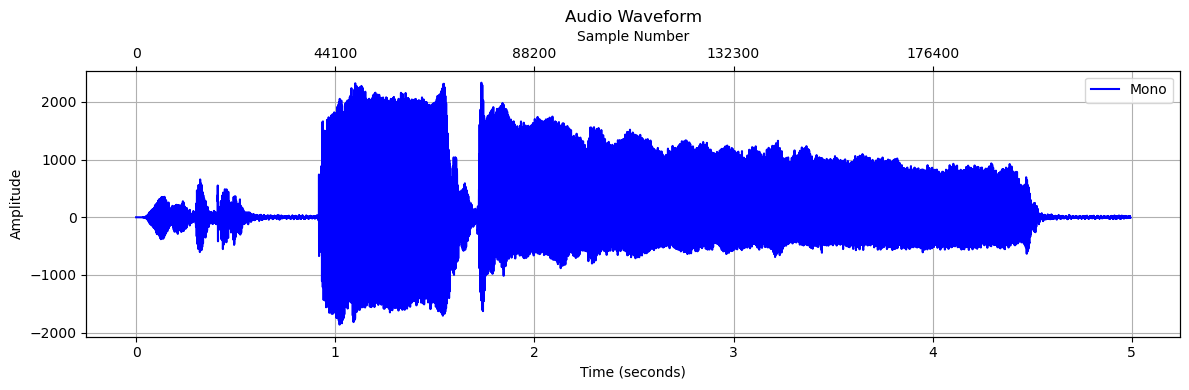

In [38]:
import matplotlib.pyplot as plt

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Crop audio array
def crop_waveform(audio_array, sample_rate, num_channels, seconds_range):
    if (len(seconds_range) == 2):
        start_sample, end_sample = seconds_range[0]*sample_rate, seconds_range[1]*sample_rate
        print(f"samples range {start_sample}:{end_sample}")
        audio_subarray = audio_array[int(start_sample):min(int(end_sample), audio_array.shape[0])]
    else:
        raise ValueError(f"Unsupported seconds_range len {len(seconds_range)}")
    return audio_subarray

# Function to plot the waveform
def plot_waveform(audio_array, sample_rate, num_channels, seconds_range = None):
    if audio_array is None:
        print("Cannot plot: Audio data not loaded.")
        return
    
    if (seconds_range is None):
        audio_subarray = audio_array
    elif (len(seconds_range) == 2):
        audio_subarray = crop_waveform(audio_array, sample_rate, num_channels, seconds_range)
    else:
        raise ValueError(f"Unsupported seconds_range len {len(seconds_range)}")
    
    # Calculate duration of the audio
    num_samples = audio_subarray.shape[0]
    duration = num_samples / sample_rate
    # Create time axis
    time_axis = np.linspace(0, duration, num_samples)
    
    sample_axis = np.arange(num_samples)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 4))
    
    if num_channels == 1:  # Mono
        ax.plot(time_axis, audio_subarray, label='Mono', color='blue')
    elif num_channels == 2:  # Stereo
        ax.plot(time_axis, audio_subarray[:, 0], label='Left Channel', color='blue', alpha=0.7)
        ax.plot(time_axis, audio_subarray[:, 1], label='Right Channel', color='orange', alpha=0.7)
    
    # Set primary x-axis (time in seconds)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Audio Waveform')
    ax.legend()
    ax.grid(True)
    
# Add secondary x-axis (sample numbers)
    ax2 = ax.twiny()  # Create a twin x-axis sharing the same y-axis
    
    # Set secondary axis limits to match primary axis (in time units)
    ax2.set_xlim(ax.get_xlim())  # Align with time axis limits
    
    # Get primary axis tick positions (in seconds)
    time_ticks = ax.get_xticks()
    # Filter ticks to ensure they are within bounds
    time_ticks = time_ticks[(time_ticks >= 0) & (time_ticks <= duration)]
    
    # Convert time ticks to sample numbers
    sample_ticks = time_ticks * sample_rate
    sample_ticks = sample_ticks.astype(int)  # Ensure integer sample numbers
    
    # Set secondary axis ticks
    ax2.set_xticks(time_ticks)  # Place ticks at same positions as time ticks
    ax2.set_xticklabels([f'{s}' for s in sample_ticks])
    ax2.set_xlabel('Sample Number')
    
    # Diagnostic output to verify alignment
    print("Primary x-axis ticks (seconds):", time_ticks)
    print("Secondary x-axis ticks (samples):", sample_ticks)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Display the plot
    plt.show()

plot_waveform(audio_array, sample_rate=sample_rate,num_channels=1)

samples range 66150.0:88200.0
Primary x-axis ticks (seconds): [0.  0.1 0.2 0.3 0.4]
Secondary x-axis ticks (samples): [    0  4410  8820 13230 17640]


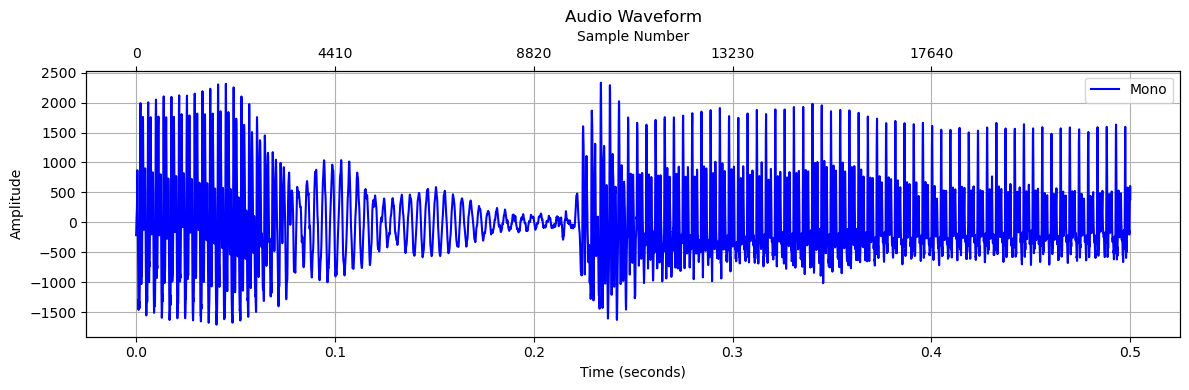

In [39]:
# recording-aba.wav
#seconds_range = [0.85,0.95]
seconds_range = [1.5,2.0]
# Amit
#seconds_range = [1.2,1.3]
#seconds_range = [2.5,2.6]

plot_waveform(audio_array, sample_rate=sample_rate,num_channels=1,seconds_range=seconds_range)


In [40]:
audio_array_cropped = crop_waveform(audio_array, sample_rate, num_channels, seconds_range)

samples range 66150.0:88200.0


In [41]:
corr_patch = audio_array_cropped[0:audio_array_cropped.shape[0]//5] # fifth of the cropped signal

In [42]:
from numpy.lib.stride_tricks import sliding_window_view

sliding_window_view_audio = sliding_window_view(audio_array_cropped, window_shape=corr_patch.shape[0])
print('sliding_window_view_audio.shape', sliding_window_view_audio.shape)
corr_values = -1*np.sum(np.abs(np.subtract(sliding_window_view_audio, corr_patch)), axis=1)
corr_values = corr_values - np.min(corr_values)
print(corr_values.shape)


sliding_window_view_audio.shape (17641, 4410)
(17641,)


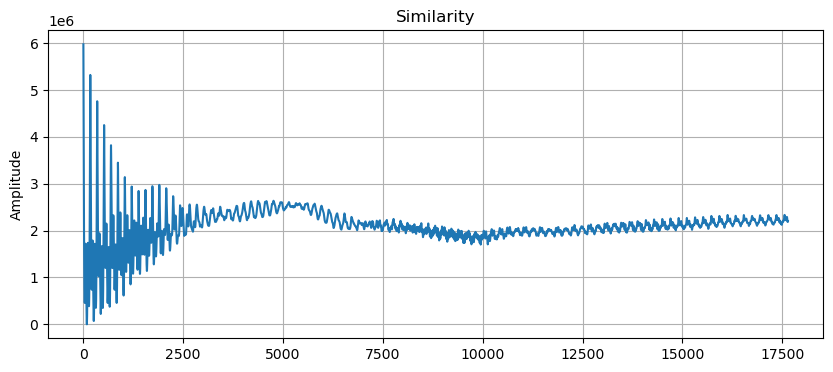

In [43]:
plt.figure(figsize=(10, 4))
plt.plot(corr_values)
plt.ylabel('Amplitude')
plt.title('Similarity')
plt.grid(True)
plt.show()

In [44]:
from scipy.signal import find_peaks

max_value = np.max(corr_values[100:]) #ignore the first 10 samples due to strong corr
peaks, values = find_peaks(corr_values, height=max_value*0.7, rel_height=0.9)
print(f"number of peaks is {len(peaks)}")
print(f"peaks = {peaks}")
peaks_values = corr_values[peaks]
print(f"peaks values = {peaks_values}")
#sorted_peaks_values = sorted(peaks_values, reverse=True)
#print(f"sorted peaks values = {sorted_peaks_values}")
diff_peaks = peaks[1:]-peaks[:-1]
print(f"diff_peaks = {diff_peaks}")
print(np.median(np.asarray(diff_peaks)))

number of peaks is 4
peaks = [173 346 519 692]
peaks values = [5321453 4759772 4251216 3820954]
diff_peaks = [173 173 173]
173.0
